In [1]:
#this is mainly for improving the current sign languange detection model
#main goals: improve inference speed and real time accuracy

In [1]:
import os
import cv2
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import (
    SelectKBest, 
    f_classif,  # ANOVA F-value between label/feature
    mutual_info_classif  # Mutual information
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Conv1D, MaxPooling1D, GRU, TimeDistributed, Flatten ,Conv2D, Conv3D, MaxPooling3D, BatchNormalization, Reshape, Lambda, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
# Paths and constants
DATA_PATH = 'DATA'  # Path to save videos and keypoints
# DATA_PATH = 'NEW_DATA'  # Path to save new videos and keypoints for adding new data
# accumulated actions
ACTIONS = np.array(['Hi', 'Saya Sayang Awak', 'Makan',
                   'Selamat Malam', 'Terima Kasih', 'Apa Khabar',
                   'Awak', 'Saya', 'Minum',
                   'Salah', 'Betul', 'Minta Maaf',
                   'Tolong', 'Hijau', 'Kita',
                   'Mereka', 'Ini', 'Itu',
                   'Apa', 'Siapa',
                    'Ini Di Luar Pengetahuan Saya',
                    'Khabar Baik', 'Sama-sama'
                   ])

# new actions to be added to the dataset
# ACTIONS = np.array(['Ini Di Luar Pengetahuan Saya'])

# OLD_ACTIONS = np.array(['Hi', 'Saya Sayang Awak', 'Makan'])
# NEW_ACTIONS = np.array(['Selamat Malam', 'Terima Kasih', 'Apa Khabar'])


NO_SEQUENCES = 150  # Number of videos per action
SEQUENCE_LENGTH = 30  # Frames per video

In [3]:
def resample_keypoints(keypoints, target_length=30):
    """
    Resamples the given keypoints array to the target number of frames.

    Args:
        keypoints (np.ndarray): Keypoints array of shape (original_length, num_features).
        target_length (int): Desired number of frames.

    Returns:
        np.ndarray: Resampled keypoints array of shape (target_length, num_features).
    """
    original_length = keypoints.shape[0]
    if original_length == target_length:
        return keypoints
    indices = np.linspace(0, original_length - 1, target_length, dtype=np.int32)
    return keypoints[indices]

# Mediapipe setup
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    return image, results

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33 * 4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)
    return np.concatenate([pose, lh, rh])

def extract_keypoints_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints = []
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            _, results = mediapipe_detection(frame, holistic)
            keypoint_frame = extract_keypoints(results)
            keypoints.append(keypoint_frame)

    cap.release()
    return np.array(keypoints)

def process_videos_to_keypoints(start_sequence=0, end_sequence=None):
    """
    Process videos to extract keypoints and save as .npy files,
    keeping .npy indices aligned with video indices.
    """
    for action in ACTIONS:
        action_path = os.path.join(DATA_PATH, action)
        
        # Get all video files in the action directory
        video_files = [f for f in os.listdir(action_path) if f.endswith(".mp4")]
        
        # Sort files numerically based on the numeric part of their names
        video_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
        
        # If end_index is None, process all files from start_index onwards
        if end_sequence is None:
            end_sequence = len(video_files)
        
        for video_file in video_files[start_sequence:end_sequence]:
            # Extract the numeric index from the video filename
            video_index = int(''.join(filter(str.isdigit, os.path.splitext(video_file)[0])) or 0)
            
            video_path = os.path.join(action_path, video_file)
            keypoints = extract_keypoints_from_video(video_path)
            
            # Save keypoints as .npy, ensuring consistent zero-based naming
            npy_path = os.path.join(action_path, f"{video_index}.npy")
            np.save(npy_path, keypoints)
            print(f"Processed and saved keypoints for Action({action}) {video_file} as {video_index}.npy")
            
def load_data(target_length=30):
    sequences, labels = [], []
    label_map = {action: idx for idx, action in enumerate(ACTIONS)}

    for action in ACTIONS:
        for sequence in range(NO_SEQUENCES):
            npy_path = os.path.join(DATA_PATH, action, f"{sequence}.npy")
            try:
                # Load the keypoints
                keypoints = np.load(npy_path)
                
                # Resample keypoints to the target length
                keypoints_resampled = resample_keypoints(keypoints, target_length=target_length)
                
                sequences.append(keypoints_resampled)
                labels.append(label_map[action])
            except FileNotFoundError:
                print(f"File not found: {npy_path}. Skipping.")
                continue

    x = np.array(sequences)
    y = to_categorical(labels, num_classes=len(ACTIONS))
    return x, y

In [7]:
#Data Pre-processing
#load testing and training data
x, y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"Train Data:{x_train.shape} Test Data:{y_test.shape}")
#Improve Input Data Preprocessing 
#Normalize your data
#Check and augment data: Ensure your dataset has balanced classes. If not, augment the data for underrepresented classes by duplicating sequences or introducing slight noise to the sequences.

scaler = MinMaxScaler()
x_train_flat = x_train.reshape(-1, x_train.shape[-1])  # Flatten for scaling
x_test_flat = x_test.reshape(-1, x_test.shape[-1])

x_train_scaled = scaler.fit_transform(x_train_flat).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test_flat).reshape(x_test.shape)
print(f"After Preprocessing => Train Data:{x_train_scaled.shape} Test Data:{x_test_scaled.shape}")

File not found: DATA\Hijau\120.npy. Skipping.
File not found: DATA\Hijau\121.npy. Skipping.
File not found: DATA\Hijau\122.npy. Skipping.
File not found: DATA\Hijau\123.npy. Skipping.
File not found: DATA\Hijau\124.npy. Skipping.
File not found: DATA\Hijau\125.npy. Skipping.
File not found: DATA\Hijau\126.npy. Skipping.
File not found: DATA\Hijau\127.npy. Skipping.
File not found: DATA\Hijau\128.npy. Skipping.
File not found: DATA\Hijau\129.npy. Skipping.
File not found: DATA\Hijau\130.npy. Skipping.
File not found: DATA\Hijau\131.npy. Skipping.
File not found: DATA\Hijau\132.npy. Skipping.
File not found: DATA\Hijau\133.npy. Skipping.
File not found: DATA\Hijau\134.npy. Skipping.
File not found: DATA\Hijau\135.npy. Skipping.
File not found: DATA\Hijau\136.npy. Skipping.
File not found: DATA\Hijau\137.npy. Skipping.
File not found: DATA\Hijau\138.npy. Skipping.
File not found: DATA\Hijau\139.npy. Skipping.
File not found: DATA\Hijau\140.npy. Skipping.
File not found: DATA\Hijau\141.npy

In [32]:
# Build New CNN + LSTM Model
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # 1D Convolutional Layers for Feature Extraction
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # LSTM Layers for Temporal Dependencies
    model.add(LSTM(128, return_sequences=True, activation='tanh'))
    model.add(LSTM(64, return_sequences=False, activation='tanh'))

    # Fully Connected Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Output Layer with Softmax Activation for Multi-class Classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the Model
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

# Build the model
input_shape = (SEQUENCE_LENGTH, x_train.shape[2])  # Replace `x_train.shape[2]` with the actual feature dimension if needed
num_classes = len(ACTIONS)  # Number of action classes
model = build_cnn_lstm_model(input_shape, num_classes)

# Display model summary
model.summary()

# Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 30, 64)            49600     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 15, 64)            0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 15, 64)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 15, 128)           24704     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 7, 128)           

In [13]:
def build_tcn_model(input_shape, num_classes):
    model = Sequential()

    # Temporal Convolutions
    model.add(Input(shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))

    # Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

# Build the model
input_shape = (SEQUENCE_LENGTH, x_train.shape[2])  # Replace `x_train.shape[2]` with the actual feature dimension if needed
num_classes = len(ACTIONS)  # Number of action classes
model = build_tcn_model(input_shape, num_classes)

# Display model summary
model.summary()

# Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=70,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 30, 64)            49600     
                                                                 
 conv1d_16 (Conv1D)          (None, 30, 128)           24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 15, 128)           0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 15, 128)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 15, 256)           98560     
                                                                 
 global_average_pooling1d_5  (None, 256)               0         
  (GlobalAveragePooling1D)                            

In [17]:
#LSTM
def build_model(input_shape, output_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape)))
    model.add(LSTM(128, return_sequences=True, activation='tanh'))
    model.add(LSTM(128, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

model = build_model((SEQUENCE_LENGTH, x_train.shape[2]), len(ACTIONS))
model.summary()

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 128)           198144    
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 21)               

In [40]:
# Build the RCNN + LSTM model
def build_model(input_shape, num_classes):
    model = Sequential()
    
    # Input Layer
    model.add(Input(input_shape))
    
    # RCNN (Recurrent Convolutional Layers)
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(GRU(64, return_sequences=True))  # Adding a recurrent layer to the convolutional output
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(GRU(128, return_sequences=True))  # Recurrent connection in the second convolutional layer
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    # LSTM Layers for Temporal Dependencies
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    
    # Fully Connected Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    
    # Output Layer with Softmax Activation for Multi-class Classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the Model
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model 

model = build_model((SEQUENCE_LENGTH, x_train.shape[2]), len(ACTIONS))
model.summary()

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]
)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 30, 64)            49600     
                                                                 
 gru_6 (GRU)                 (None, 30, 64)            24960     
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 15, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 15, 64)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 15, 128)           24704     
                                                                 
 gru_7 (GRU)                 (None, 15, 128)           99072     
                                                     

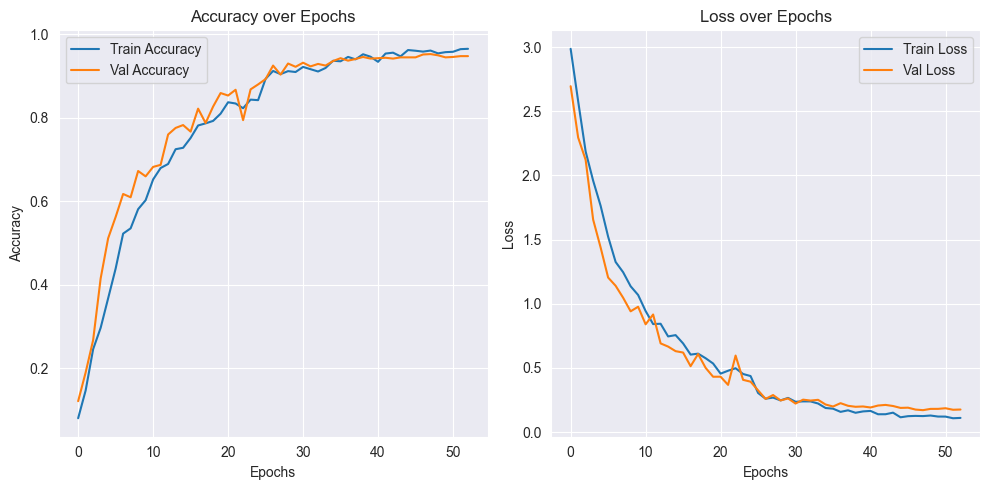

In [14]:
# Plot Training History
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

32/32 [==============================] - 0s 3ms/step
Confusion Matrix:
 [[46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 56  2  1  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  1]
 [ 0  0 43  0  0  0  0  0  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 35  0  2  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 40  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 46  0  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 34  0  0  0  2  0  0  0  0

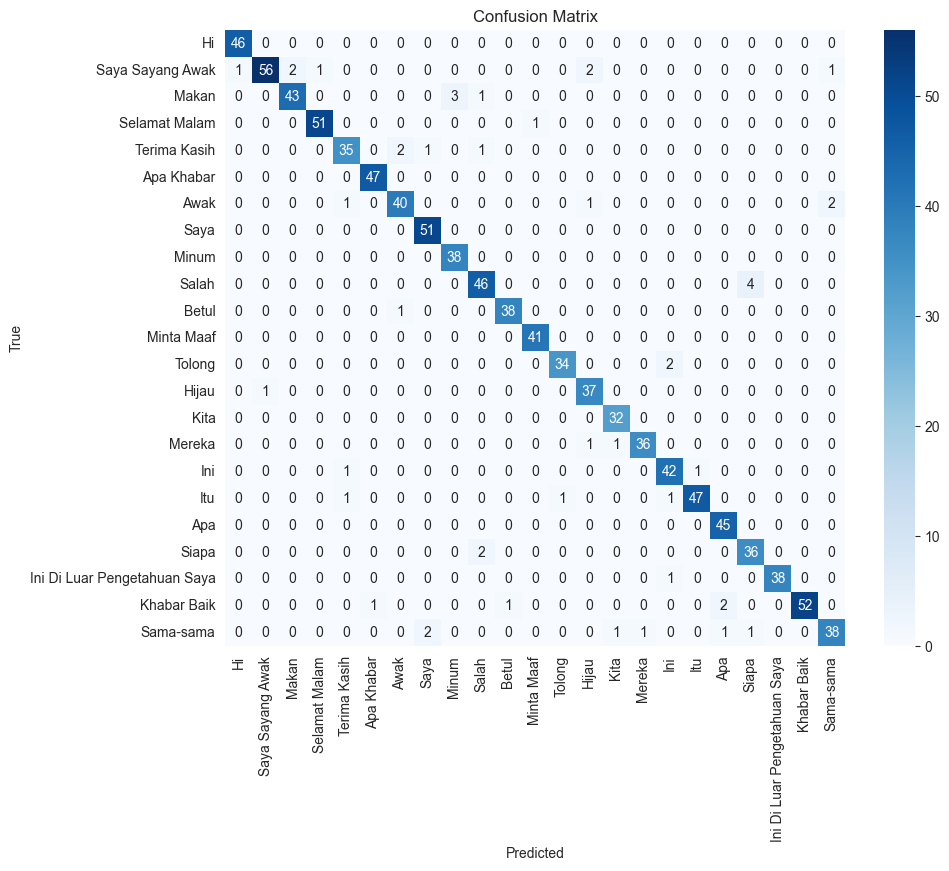

In [15]:
# Predict on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy Score:", accuracy)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIONS, yticklabels=ACTIONS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# Model Name Declaration
model_codename = "video_model_TCN_v3.keras"

In [17]:
#Save the model
model.save(model_codename)

In [5]:
# Test the model in real-time
def real_time_test(model):
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5

    cap = cv2.VideoCapture(0)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process frame
            _, results = mediapipe_detection(frame, holistic)
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-SEQUENCE_LENGTH:]
            
            # Predict action
            if len(sequence) == SEQUENCE_LENGTH:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(res)
                predictions.append(np.argmax(res))
                
                if res[np.argmax(res)] > threshold:
                    action = ACTIONS[np.argmax(res)]
                    sentence.append(action)

            # Display prediction
            # Assuming `frame` is the video frame
            frame_height, frame_width, _ = frame.shape  # Get the frame dimensions
            
            # Define rectangle at the bottom
            cv2.rectangle(frame, (0, frame_height - 40), (frame_width, frame_height), (255, 255, 255), -1)
            
            # Add text inside the rectangle
            cv2.putText(frame, ' '.join(sentence[-1:]), (10, frame_height - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (13, 13, 13), 2, cv2.LINE_AA)
            cv2.imshow("Sign Language Recognition", frame)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

model = tf.keras.models.load_model(model_codename)
real_time_test(model)




1/1 [==============================] - 0s 333ms/step
[2.2373619e-03 4.6549629e-02 3.4599262e-04 9.6334988e-06 3.8897380e-04
 7.1662212e-06 1.8355303e-02 2.8285400e-03 6.6434282e-06 1.9160373e-04
 4.3084001e-06 1.5166391e-07 1.4538617e-05 3.2875378e-04 1.1248650e-01
 7.0259492e-05 4.9361292e-06 4.5041052e-05 4.6797313e-06 9.8085482e-05
 4.9064285e-03 7.5454850e-06 8.1110793e-01]
1/1 [==============================] - 0s 30ms/step
[5.38907654e-04 3.45939547e-02 1.52900393e-04 3.84319992e-06
 1.90958046e-04 4.52429185e-06 1.35570215e-02 2.14213179e-03
 1.90080084e-06 8.87425267e-05 1.58896057e-06 5.97104446e-08
 4.49125037e-06 2.59746012e-04 8.95851627e-02 2.82200053e-05
 1.18689161e-06 1.25392589e-05 1.79473182e-06 5.16604850e-05
 3.19030904e-03 3.29158297e-06 8.55584979e-01]
1/1 [==============================] - 0s 26ms/step
[1.0667858e-04 2.9531313e-02 5.8328176e-05 1.1969946e-06 7.3517898e-05
 2.3266348e-06 8.3935726e-03 1.7837823e-03 5.0022652e-07 2.9664956e-05
 5.5845413e-07 2.2

In [6]:
# Load the model in TensorFlow 2.16.1 environment
model = tf.keras.models.load_model("video_model_TCN_v3.keras")

# Save the model in HDF5 format (more compatible with older versions)
# model.save("video_model_CNN_LSTM_v10.h5")
# model.save("model")
model.export('final_model')

INFO:tensorflow:Assets written to: final_model\assets


INFO:tensorflow:Assets written to: final_model\assets


Saved artifact at 'final_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 258), dtype=tf.float32, name='input_6')
Output Type:
  TensorSpec(shape=(None, 23), dtype=tf.float32, name=None)
Captures:
  1344265533952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344265530080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344265532016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344264843536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344265534128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344264835968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344265523392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344264832448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344163502160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344163504096: TensorSpec(shape=(), dtype=tf.resource, name=None)
